# Install Libraries

In [1]:
!pip install transformers

# !pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 65.6 MB/s eta 0:00:00


# Packages

In [2]:
import torch
import transformers
import spacy
import numpy as np
import json,time
from pathlib import Path

In [3]:
# creates a torch.device object that represents the device (GPU or CPU) on which the computation will be executed.

device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

In [4]:
# Load BERT-base-uncased model and tokenizer

model = transformers.BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=8).to(device)
# model = transformers.BertForQuestionAnswering.from_pretrained('bert-base-uncased', num_labels=8).to(device)
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

# Loading SquadV2 Dataset

In [5]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

# Load SQuAD v2 dataset and preprocess data

!mkdir squadV2_ds
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squadV2_ds/train-v2.0.json
# !wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squadV2_ds/dev-v2.0.json

--2023-02-24 15:30:40--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.111.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42123633 (40M) [application/json]
Saving to: ‘squadV2_ds/train-v2.0.json’

squadV2_ds/train-v2 100%[===================>]  40.17M  --.-KB/s    in 0.1s    

2023-02-24 15:30:43 (321 MB/s) - ‘squadV2_ds/train-v2.0.json’ saved [42123633/42123633]



# Retrieve and Store the data

In [6]:
# Give the path for train data
path = Path('/content/squadV2_ds/train-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer['text'])

passages, questions, answers = texts, queries, answers

In [7]:
passages = passages[:8]
questions = questions[:8]
answers = answers[:8]
print(len(passages))
print(len(questions))
print(len(answers))

print("Passage: ",passages[0])  
print("Query: ",questions[0])
print("Answer: ",answers[0])

# print(questions[0].split(" ", 1)[0])

8
8
8
Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  in the late 1990s


# Tokenization 







In [8]:
input_ids = []
attention_masks = []

# iterates through pairs of passages and answers and calls tokenizer.encode_plus() on each pair.
# tokenizes a piece of text(passages, answers) and returns a dictionary containing various pieces of information about the tokens.
''' 
  the resulting dictionary contains two keys: input_ids and attention_mask. 
  input_ids is a tensor that contains the token IDs of the input sequence,
  and attention_mask is a tensor that contains a binary mask indicating which tokens are padding and which ones are not.
'''
for passage, answer in zip(passages, answers):
    encoded_dict = tokenizer.encode_plus(
                        answer,
                        passage,
                        add_special_tokens = True,
                        max_length = 512,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Entity Name Recognition

In [9]:
# Obtain entity type of answer using spaCy and create learnable embedding

nlp = spacy.load('en_core_web_sm')
entity_types = []
for answer in answers:
    doc = nlp(answer)
    if doc.ents:
        entity_types.append(doc.ents[0].label_)
    else:
        entity_types.append('None')


# printing frequancy of each label in dataset
print('label     :   frequance')
for label in nlp.get_pipe("ner").labels:
  print(label,"  :  ",entity_types.count(label))
print('None',"   :  ",entity_types.count('None'))


# create array for each entity 
entity_type_embeddings = np.zeros((len(entity_types), 5))

# dictionary to map each entity to its tensor
entity_type_dict = {'PERSON': [1, 0, 0, 0, 0], 'CARDINAL': [0, 1, 0, 0, 0], 'DATE': [0, 0, 1, 0, 0], 'ORG': [0, 0, 0, 1, 0], 'GPE': [0, 0, 0, 0, 1], 'None': [0, 0, 0, 0, 0]}


for i, entity_type in enumerate(entity_types):
    try:
      entity_type_embeddings[i] = np.array(entity_type_dict[entity_type])
    except:  
      entity_type_embeddings[i] = np.array(entity_type_dict['None'])

label     :   frequance
CARDINAL   :   0
DATE   :   3
EVENT   :   0
FAC   :   0
GPE   :   1
LANGUAGE   :   0
LAW   :   0
LOC   :   0
MONEY   :   0
NORP   :   0
ORDINAL   :   0
ORG   :   0
PERCENT   :   0
PERSON   :   1
PRODUCT   :   1
QUANTITY   :   0
TIME   :   0
WORK_OF_ART   :   1
None    :   1


# FeedForward Network

In [10]:
class FFN(torch.nn.Module):
    def __init__(self, hidden_size, num_classes):
        super().__init__()
        self.fc1 = torch.nn.Linear(hidden_size, num_classes).to(device)
        self.softmax = torch.nn.Softmax(dim=-1).to(device)

    def forward(self, x):
        out = self.fc1(x)
        out = self.softmax(out)
        return out

# Extract Question Word 

In [11]:
# dictionary to map each token
interrogative_words = {'who':0, 'what':1, 'when':2, 'where':3, 'why':4, 'how':5,'which':6,'others':7}

found_interrogative_words = []
for q in questions:
  words = tokenizer.tokenize(q)
  for word in words:
    found=False
    if word.lower() in interrogative_words:
        found=True
        found_interrogative_words.append(interrogative_words[word.lower()])
        break
  if found==False:
        found_interrogative_words.append(interrogative_words['others'])

In [12]:
# Convert data to tensors 

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
entity_type_embeddings = torch.from_numpy(entity_type_embeddings)
interrogative_words_labels=torch.tensor(found_interrogative_words,dtype=torch.int64)
# interrogative_words_labels=torch.reshape(interrogative_words_labels,(-1,1))

# print(input_ids.shape)
# print(len(entity_type_embeddings))
# print(len(interrogative_words_labels))


# Loading Data to TensorDataset 

In [13]:
dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, entity_type_embeddings,interrogative_words_labels)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4,shuffle=True)


# Base Model

In [14]:
# Train the model on the SQuAD v2 dataset
ffn = FFN(hidden_size=773, num_classes=8)
optimizer = torch.optim.Adam(ffn.parameters(), lr=5e-5, weight_decay=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

train_losses = []

for epoch in range(3):
    epoch_time = time.time()

    # Set model in train mode
    model.train()
    
    loss_of_epoch = 0
    for batch in dataloader:
      
        optimizer.zero_grad()
        input_ids_batch, attention_masks_batch, entity_type_embeddings_batch,labels= tuple(t.to(device) for t in batch)
        outputs = model(input_ids_batch, attention_mask=attention_masks_batch, labels=labels,output_hidden_states=True)

        cls_tensor = outputs.hidden_states[-1]
        # https://discuss.huggingface.co/t/how-to-get-cls-embeddings-from-bertfortokenclassification-model/9276/2#:~:text=The%20shape%20of%20last_hidden_states%20will%20be%20%5Bbatch_size%2C%20tokens%2C%20hidden_dim%5D%20so%20if%20you%20want%20to%20get%20the%20embedding%20of%20the%20first%20element%20in%20the%20batch%20and%20the%20%5BCLS%5D%20token%20you%20can%20get%20it%20with%20last_hidden_states%5B0%2C0%2C%3A%5D.
        cls_tensor = cls_tensor[:,0,:]
        cls_tensor = cls_tensor
        ner_tensor = entity_type_embeddings_batch.to(torch.float32)

        # Concatenate the tensors along the first dimension
        concat_tensor = torch.cat((cls_tensor, ner_tensor),dim=1).to(device)

        logits = ffn(concat_tensor)
        predictions = torch.argmax(logits, dim=1)

        
        loss = loss_fn(predictions.float(), labels.float())
        loss.requires_grad = True
        loss.backward()
        optimizer.step()
        loss_of_epoch += loss.item()
    loss_of_epoch /= len(dataloader)
    train_losses.append(loss_of_epoch)
    print("\n-------Epoch ", epoch+1,
      "-------"
      "\n Training Loss:", train_losses[-1],
      "\n Time: ",(time.time() - epoch_time),
      '\n predictions :',predictions,
      '\n actual :',labels,
      "\n-----------------------","\n\n")

# Evaluate the model on the SQuAD v2 dataset
# model.eval()
# with torch.no_grad():
#     input_ids = []
#     attention_masks = []
#     entity


-------Epoch  1 -------
 Training Loss: 39.90177536010742 
 Time:  2.7156739234924316 
 predictions : tensor([7, 0, 7, 0], device='cuda:0') 
 actual : tensor([0, 1, 2, 1], device='cuda:0') 
----------------------- 



-------Epoch  2 -------
 Training Loss: 29.372285842895508 
 Time:  0.2390758991241455 
 predictions : tensor([0, 7, 3, 0], device='cuda:0') 
 actual : tensor([6, 2, 1, 1], device='cuda:0') 
----------------------- 



-------Epoch  3 -------
 Training Loss: 15.468619346618652 
 Time:  0.24027705192565918 
 predictions : tensor([0, 0, 0, 0], device='cuda:0') 
 actual : tensor([1, 0, 1, 2], device='cuda:0') 
----------------------- 




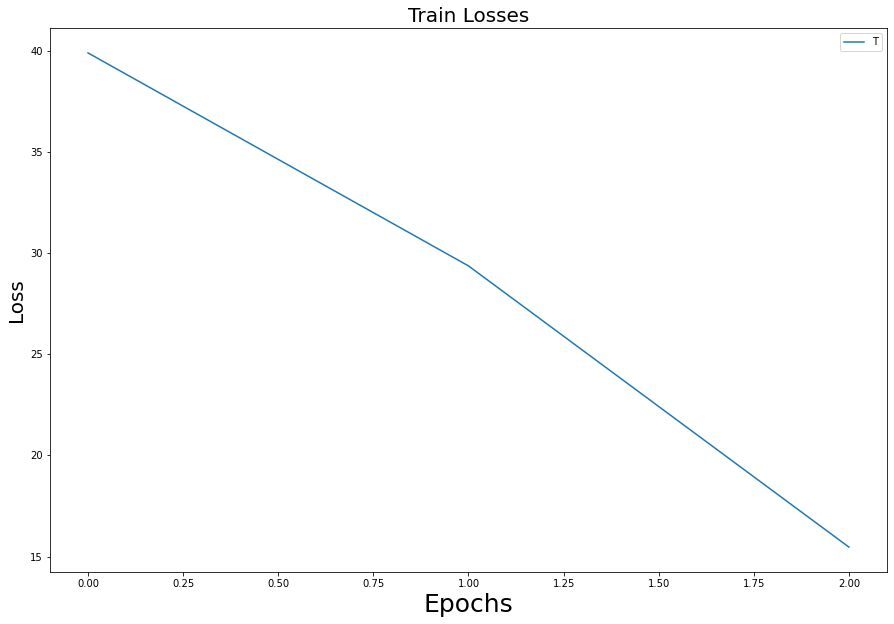

In [15]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 

_=ax.plot(train_losses)
# _=ax.plot(val_losses)
# _=ax.legend(('Train','Val'),loc='upper right')
_=ax.legend(('Train'),loc='upper right')